In [32]:
import json
from collections import defaultdict
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.plot import plot_quant_vs_ogtt
# from src.utils import tight_bbox, parse_lipid
from src import utils

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns 

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks'
sns.set_style('ticks')

In [4]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
colors['Non-fasted'] = colors['RBG']
colors['Fasted'] = colors['FBG']
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

In [5]:
data['signif_interaction'] = data['qval_sampling:ogtt'] < 0.05
data['signif_sampling'] = data['qval_sampling'] < 0.05
gb_means = (data
            .loc[:, data_cols]
            .groupby(fg['bg_type'], axis=1)
            .mean()
           )

data['fasted_mean'] = gb_means['FBG']
data['fed_mean'] = gb_means['RBG']
data['Log2 Fold Change'] = data['fed_mean'] - data['fasted_mean']

data['Fed - Fasted slope'] = data['coef_fed'] - data['coef_fasted']
data['signif_sampling'] = data['qval_sampling'] < 0.05
data['signif_interact'] = data['qval_sampling:ogtt'] < 0.05
data['log_qval_sampling'] = -np.log10(data['qval_sampling'])
data['log_qval_ogtt'] = -np.log10(data['qval_ogtt'])
data['log_qval_sampling:ogtt'] = -np.log10(data['qval_sampling:ogtt'])
data['is_id'] = data['superclass'] != 'Unidentified'

In [54]:
importlib.reload(utils)

<module 'src.utils' from 'D:\\nile_rat_multiomics\\notebooks\\..\\src\\utils.py'>

In [173]:
ldf = data.loc[(data['Type'] == 'lipid') & (data['ID'] != 'Unidentified')].copy()
ldf['FA'] =          ldf['ID'].apply(lambda x: utils.parse_lipid(x)[5])
ldf['is_sum_comp'] = ldf['ID'].apply(lambda x: utils.parse_lipid(x)[6])
# Drop FA because they're not really lipid headgroups plus FA, they're just FA
ldf = ldf.loc[(ldf['is_sum_comp'] == False) & (ldf['molec_class'] != 'FA')]
ldf

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,fed_mean,Log2 Fold Change,Fed - Fasted slope,signif_interact,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,FA,is_sum_comp
i,,,,,,,,,,,,,,,,,,,,,
l_0,AC 5:0_5.964_246.17,AC 5:0,246.16996,5.964,AC,lipid,+,HILIC,Fatty Acyl,20.773834,...,22.221564,1.192264,0.000015,False,17.154281,1.256572,1.021858,True,"[(5, 0)]",False
l_1,AC 4:0_7.082_232.1543,AC 4:0,232.15435,7.082,AC,lipid,+,HILIC,Fatty Acyl,19.846289,...,20.299460,0.558147,0.000013,False,6.896716,5.254354,0.752578,True,"[(4, 0)]",False
l_2,AC 3:0_7.805_218.1387,AC 3:0,218.13868,7.805,AC,lipid,+,HILIC,Fatty Acyl,20.218725,...,22.348722,1.864898,0.000006,False,24.141198,1.782656,0.248644,True,"[(3, 0)]",False
l_3,AC 2:0_8.718_204.1231,AC 2:0,204.12313,8.718,AC,lipid,+,HILIC,Fatty Acyl,26.515578,...,25.398966,-1.047007,0.000011,False,19.034099,3.441713,0.916667,True,"[(2, 0)]",False
l_4,AC 18:2_2.271_424.3421,AC 18:2,424.34207,2.271,AC,lipid,+,HILIC,Fatty Acyl,20.713250,...,18.176490,-2.528536,0.000032,False,19.131919,0.568868,1.188424,True,"[(18, 2)]",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
l_893,TG 18:2_18:1_22:0_19.221_958.8799,TG 18:2_18:1_22:0,958.87994,19.221,TG,lipid,+,RP,Glycerolipid,17.428896,...,21.272277,1.767770,0.000053,False,6.875144,2.134603,1.177834,True,"[(18, 2), (18, 1), (22, 0)]",False
l_895,TG 16:0_18:0_18:0_19.251_880.8339,TG 16:0_18:0_18:0,880.83392,19.251,TG,lipid,+,RP,Glycerolipid,20.812277,...,22.744776,0.926160,0.000050,True,3.425274,4.176946,1.412088,True,"[(16, 0), (18, 0), (18, 0)]",False
l_900,TG 18:2_18:1_23:0_19.553_972.897,TG 18:2_18:1_23:0,972.89703,19.553,TG,lipid,+,RP,Glycerolipid,15.692450,...,18.906788,0.690486,0.000062,False,1.260831,1.147472,1.188424,True,"[(18, 2), (18, 1), (23, 0)]",False


In [232]:
s = set()
for entry in ldf['FA']:
    for fa in entry:
        s.add(fa)
s = list(s)
s = sorted(s, key=lambda x: (x[0], x[1]))
        
for fa in s:
#     fa_str = f'{fa[0]}:{fa[1]}'
#     print(fa_str)
    ldf[fa] = ldf['FA'].apply(lambda x: fa in x)

In [233]:
ratios = {}
for fa in s:
    adf = ldf.loc[ldf[fa]]
    if len(adf) > 2:
        ratios[fa] = {}
#         ratios[fa]['total'] = len(adf)
        print(fa, len(adf))
        ratios[fa]['ns'] = len(adf.loc[adf['qval_sampling'] > 0.05])
        
        ratios[fa]['fed_higher'] = len(adf.loc[(adf['qval_sampling'] < 0.05) & (adf['Log2 Fold Change'] > 0)])
        ratios[fa]['fasted_higher'] = len(adf.loc[(adf['qval_sampling'] < 0.05) & (adf['Log2 Fold Change'] < 0)])
            

(14, 0) 5
(15, 0) 5
(16, 0) 39
(16, 1) 4
(17, 0) 9
(18, 0) 50
(18, 1) 35
(18, 2) 52
(18, 3) 3
(19, 0) 5
(20, 0) 8
(20, 2) 3
(20, 3) 5
(20, 4) 24
(20, 5) 19
(22, 4) 3
(22, 5) 7
(22, 6) 30


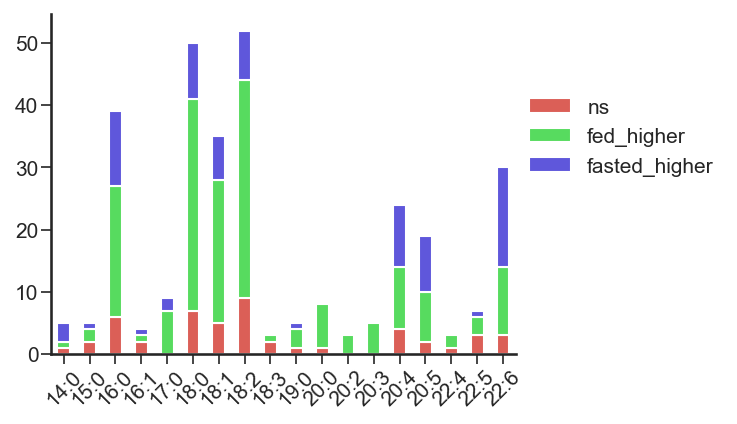

In [235]:
palette = sns.color_palette('hls', 3)

fig, ax = plt.subplots(figsize=(4,3), dpi=150)
result = pd.DataFrame(ratios)
result.columns = [str(x) for x in ratios.keys()]
# result = result.div(result.sum())  # normalize to 1
result.T.plot.bar(stacked=True, ax=ax, color=palette)
plt.legend(loc=(1.01, 0.5))

ax.set_xticklabels([f'{x[0]}:{x[1]}' for x in ratios.keys()], rotation=45)
ax.tick_params(pad=1, length=5)

sns.despine()

In [141]:
ldf.loc[ldf[(16,0)]]

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,"(22, 6)","(23, 0)","(24, 0)","(24, 1)","(24, 5)","(25, 0)","(26, 0)","(27, 3)","(29, 3)","(31, 3)"
i,,,,,,,,,,,,,,,,,,,,,
l_8,AC 16:0_2.316_400.3418,AC 16:0,400.34183,2.316,AC,lipid,+,HILIC,Fatty Acyl,21.793870,...,False,False,False,False,False,False,False,False,False,False
l_17,LysoPC 16:0_1.095_496.3399,LysoPC 16:0,496.33994,1.095,LysoPC,lipid,+,RP,Phospholipid,27.697435,...,False,False,False,False,False,False,False,False,False,False
l_33,LysoPC 16:0_1.489_496.3402,LysoPC 16:0,496.34018,1.489,LysoPC,lipid,+,RP,Phospholipid,26.875951,...,False,False,False,False,False,False,False,False,False,False
l_38,LysoPE 16:0_1.58_452.2789,LysoPE 16:0,452.27890,1.580,LysoPE,lipid,-,RP,Phospholipid,19.927100,...,False,False,False,False,False,False,False,False,False,False
l_41,LysoPC 16:0_1.613_496.3397,LysoPC 16:0,496.33969,1.613,LysoPC,lipid,+,RP,Phospholipid,28.075662,...,False,False,False,False,False,False,False,False,False,False
l_109,FA 16:0_4.6_255.2331,FA 16:0,255.23312,4.600,FA,lipid,-,RP,Fatty Acyl,26.021698,...,False,False,False,False,False,False,False,False,False,False
l_159,Alkenyl-DG P-16:0_20:5_7.558_599.504,Alkenyl-DG P-16:0_20:5,599.50403,7.558,Alkenyl-DG,lipid,+,RP,Glycerolipid,21.661307,...,False,False,False,False,False,False,False,False,False,False
l_160,PI 16:0_20:4_7.559_857.52,PI 16:0_20:4,857.52002,7.559,PI,lipid,-,RP,Phospholipid,23.029578,...,False,False,False,False,False,False,False,False,False,False
l_168,PI 16:0_18:2_7.661_833.5198,PI 16:0_18:2,833.51984,7.661,PI,lipid,-,RP,Phospholipid,21.764263,...,False,False,False,False,False,False,False,False,False,False
